# There are notes below each cell, discribing functionality

In [8]:
import numpy as np
import pandas as pd
from itertools import combinations
import fast_histogram as fh
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl

This simply imports things that will be needed for the program

In [9]:
data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/tripico.csv')
data['index0'] = data.index

Imports the data and adds the index as a column so that it can be saved when creating pairwise coincidences. This is so you can simply do the calculations to all the datapoints you will need, aka those that are gated with sumdif, and then populate a dataframe where each row is a coincidence.

If this is unclear, it should make more sense lower down.

In [10]:
data.tof = data.tof.apply(lambda tof: tof/1000)
data.x = data.x.apply(lambda x: x/1000)
data.y = data.y.apply(lambda y: y/1000)

print(data.iloc[:10])


   voltage       x       y       tof     id  index0
0      0.0   2.691  -7.866  1997.449    2.0       0
1      0.0  -5.063  10.033  3982.179    2.0       1
2      0.0  -8.710  25.460  2010.772    3.0       2
3      0.0 -24.314 -19.853  4206.748    3.0       3
4      0.0 -10.128  10.831  2116.414   61.0       4
5      0.0  30.526  -1.214  4262.539   61.0       5
6      0.0  21.959 -35.488  2098.749   63.0       6
7      0.0  -3.790  16.602  4085.537   63.0       7
8      0.0 -15.729   1.278  4095.536   63.0       8
9      0.0 -24.243  17.365  2050.762  114.0       9


This changes the units of x, y, and tof such that x and y are in mm and tof is in ns

15.2877254869032 percent of data kept
708234


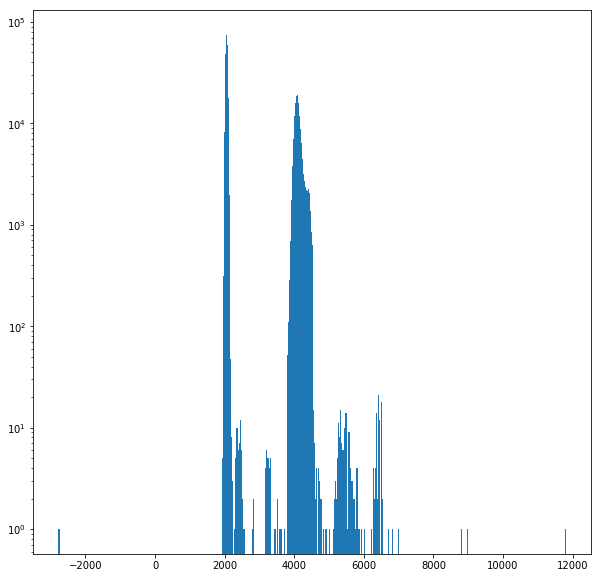

In [12]:
# if you are doing tripico, run this
value_counts = data['id'].value_counts()
coinc = data[data['id'].isin(value_counts[value_counts == 3].index)]
coinc.reset_index(inplace=True,drop=True)

print(str(coinc.shape[0]/data.shape[0]*100)+' percent of data kept') 
print(coinc.shape[0])

plt.hist(coinc.tof,bins=1000)
plt.yscale('log', nonposy='clip')
plt.rcParams["figure.figsize"] = [10,10]
plt.show()


In [14]:
#this is probably going to take forever no matter what, it is setting up every possible pairwise combination

#data = data.iloc[:2000000]

pairwise = pd.DataFrame([[k, c0, c1,c2] for k, index in data.groupby('id').index0
                                  for c0, c1 , c2 in combinations(index, 3)
                             ], columns=['id', 'index1', 'index2','index3'])





'''
pairwise = pd.DataFrame([[k, c0, c1, c2] for k, index in coinc.groupby('id').index0
                                  for c0, c1, c2 in combinations(index, 3)
                             ], columns=['id', 'index1', 'index2', 'index3'])
'''



"\npairwise = pd.DataFrame([[k, c0, c1, c2] for k, index in coinc.groupby('id').index0\n                                  for c0, c1, c2 in combinations(index, 3)\n                             ], columns=['id', 'index1', 'index2', 'index3'])\n"

In [15]:
print(pairwise.iloc[:10])

       id  index1  index2  index3
0    63.0       6       7       8
1   596.0      35      36      37
2   702.0      38      39      40
3   836.0      47      48      49
4   955.0      52      53      54
5  1257.0      73      74      75
6  1755.0      86      87      88
7  2034.0     105     106     107
8  2260.0     118     119     120
9  2545.0     133     134     135


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


6.606650186198215


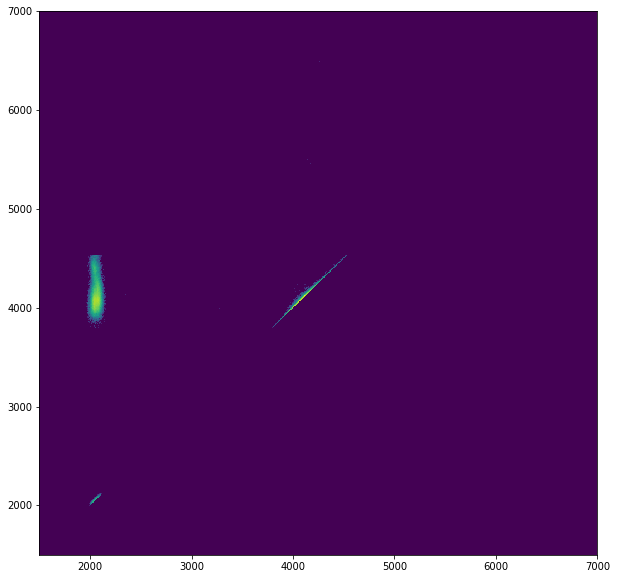

In [17]:
def pipico(tmin,tmax,binN,dataIndexes):
    
    y = data.loc[dataIndexes['index3']]['tof'].reset_index(drop=True)
    x = data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)#+data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    
    
    hist = fh.histogram2d(y,x,range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    hist = np.log(hist)
    hist[hist == -np.inf] = 0

    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


pipico(1500,7000,1000,pairwise)


Creates all pairwise combinations of detections in the same event so that sumdif gating can be applied

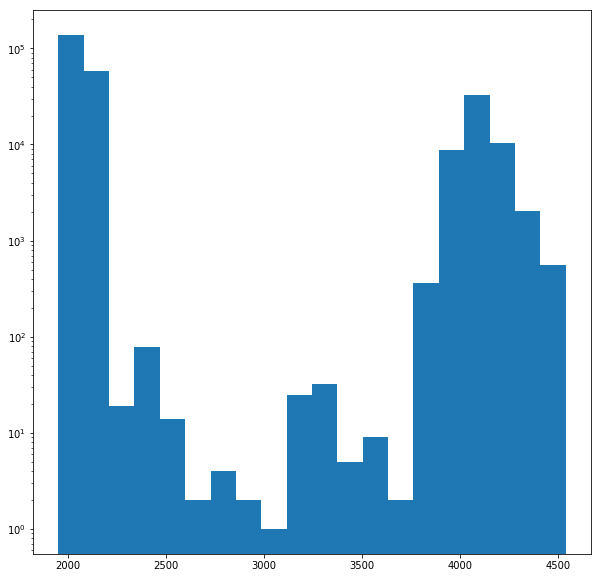

True     193040
False     57788
Name: yes, dtype: int64


In [18]:
temp = pd.DataFrame()
temp['INDEX1'] = data.iloc[pairwise['index1'].values].tof.values
temp['INDEX2'] = data.iloc[pairwise['index2'].values].tof.values
temp['INDEX3'] = data.iloc[pairwise['index3'].values].tof.values


plt.hist(temp.INDEX2,bins=20)
plt.yscale('log')
plt.show()



temp['check1'] = (temp['INDEX1']<2200)
temp['check2'] = (temp['INDEX2']<2200) 
temp['check3'] = (temp['INDEX3']>2200) 


temp['yes'] = (temp['check1'])&(temp['check2'])&(temp['check3'])
print(temp['yes'].value_counts())

cutIndexes = pairwise[temp['yes']].reset_index(drop=True)




#print(temp)
#print(indList)

This function actually goes through the process of doing the gating

In [50]:
indList = [int(col[-1]) for col in cutIndexes if col.startswith('index')]

print(cutIndexes.shape[0],'rows')
print(cutIndexes)

98344 rows
                id   index1   index2   index3
0          27298.0       92       93       94
1          40391.0      169      170      171
2          69507.0      264      265      267
3          69507.0      264      266      267
4          69507.0      265      266      267
5          93375.0      361      362      363
6          96967.0      388      389      390
7         120200.0      467      468      469
8         121121.0      470      471      472
9         126388.0      502      503      504
10        135325.0      531      532      533
11        144530.0      562      563      564
12        175071.0      657      658      659
13        176094.0      662      663      664
14        178029.0      677      678      679
15        192621.0      733      734      735
16        199040.0      748      749      750
17        211027.0      789      790      791
18        226886.0      854      855      856
19        249657.0      927      928      929
20        249875.0     

Completes the gating with the above gates.

Format: [difmin, difmax, summin, summax]

Also creates a list of the indexes numerically

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


7.080867896690782


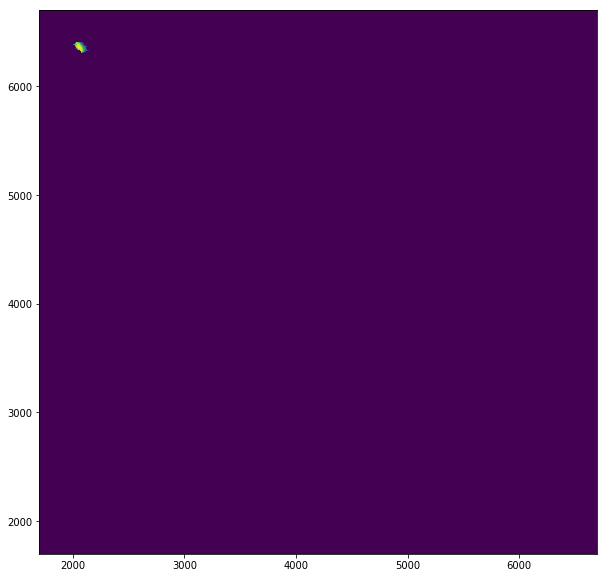

In [54]:
def tripico(tmin,tmax,binN,dataIndexes):
    
    y = data.loc[dataIndexes['index3']]['tof'].reset_index(drop=True)
    x = data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)#+data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    
    hist = fh.histogram2d(y,x,range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    hist = np.log(hist)
    hist[hist == -np.inf] = 0

    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


tripico(1700,6700,1000,cutIndexes)


In [56]:
compList = pd.DataFrame(np.unique(np.concatenate((cutIndexes['index1'].values,cutIndexes['index2'].values,cutIndexes['index3'].values),axis=0)),columns=['index0'])

Generates a dataframe with a complete list of the indexes of the datafile that were left over after the gating. The momentum and other physics calculations that just involve one particle will be done here, since you can populate the coincidence dataframe later with that info. 

(Man I love Pandas, those one-liners are so nice)

In [57]:
def dataPopulation(data,compList):
        
    temp = data.loc[compList['index0']][['x','y','tof','id','delay']]
    return temp


compList = dataPopulation(data,compList)
#compList['id'] = data.iloc[compList['index0'].values].id.reset_index(drop=True)

print(compList.iloc[:8])

          x       y       tof       id  delay
92  -24.637   2.730  2070.563  27298.0  5.163
93  -40.069 -17.009  2096.482  27298.0  5.163
94   -0.276  -0.913  6342.081  27298.0  5.163
169   6.507 -26.422  2072.341  40391.0  5.121
170  22.839  -5.443  2076.589  40391.0  5.121
171  -4.233   6.522  6341.701  40391.0  5.121
264 -13.392  -7.057  2048.020  69507.0  5.088
265  37.505   9.914  2058.843  69507.0  5.088


Fills in the data in the Dataframe of the post-cut detections

-0.03849768334083581 0.805486430571095


<Figure size 720x720 with 0 Axes>

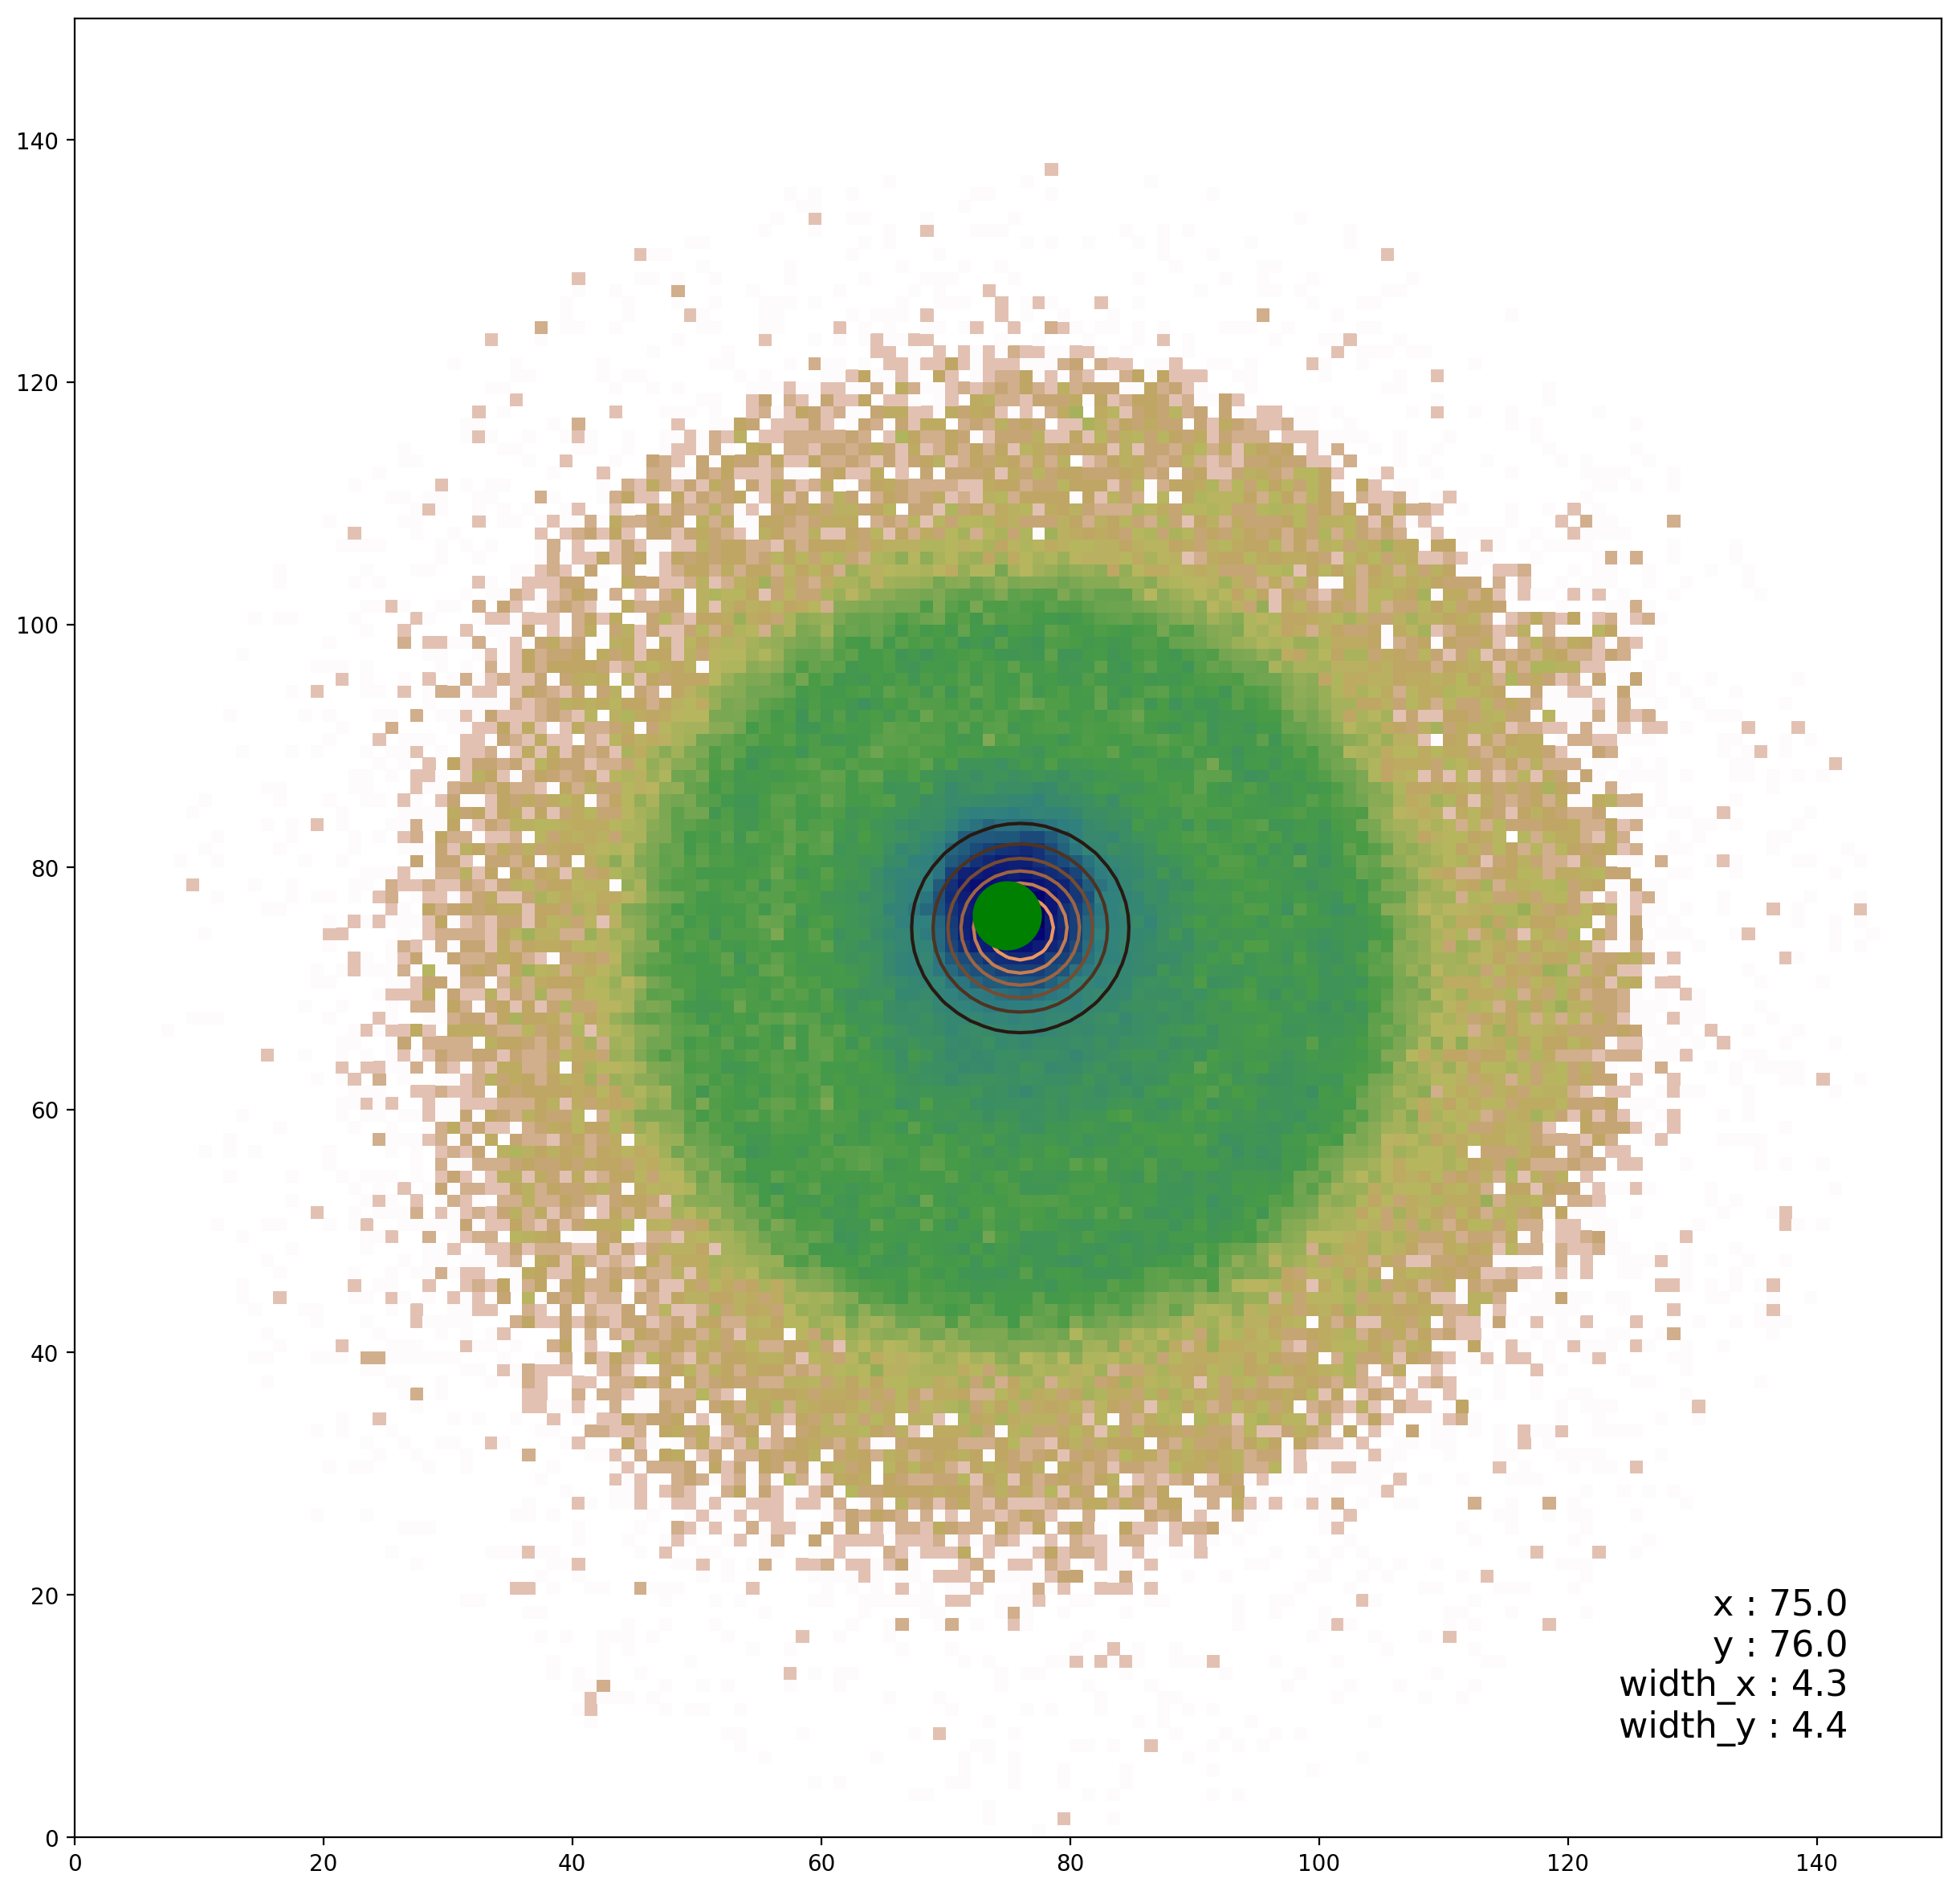

In [58]:
def getCenter(datalist):
    
    from helper import center_by_moments
    
    xmin = -60
    xmax = 60
    xbin = 150

    xy_hist = fh.histogram2d(datalist['x'],datalist['y'],range = [[xmin,xmax],[xmin,xmax]],bins = xbin)

    dx = (xmax- xmin)/xbin

    y_, x_ = np.mgrid[slice(xmin, xmax, dx),
               slice(xmin, xmax, dx)]

    x0,y0 = center_by_moments(x_[0],x_[0],xy_hist,True)
    
    return float(x0),float(y0)

x0, y0 = getCenter(compList)
print(x0,y0)

Gets the center of physics of the cut data.

In [153]:
from helper import fitEfield
from helper import GetZVelocity

E_field_new, ion_drift_length_new, t0_new = fitEfield()

print(t0_new)

ion_accel_length = 0.27

#in increasing order of mass (ie, mass of t1, mass of t2, etc)
#and the corisponding charge
mass = [1,1,39]
mass_si = [(m * 1.66056e-27) for m in mass]
charge = [1,1,1]

t0_new = 1244.3 #modify till pz is centered 


def apInd(string,ind):
    
    return string+str(ind)


<Parameter 't0', value=1270.3948332250093 +/- 2.44, bounds=[-inf:inf]>


The above cell sets up calculating the three componants of momenta. It and the two cells below are (I think) generalized for tripico as well.

Change mass and charge as needed. 

In [154]:
def filldata(compList,cutIndexes):
    
    addit = [cutIndexes]
    
    for ind in indList:
        
        temp0 = data.loc[cutIndexes[apInd('index',ind)]][['x','y','tof','delay']].reset_index(drop=True)
        temp0.columns = [apInd(col,ind) for col in temp0]
        addit.append(temp0)
  
    return pd.concat(addit, axis=1)
    

coincXYT = filldata(compList,cutIndexes)

  
print(coincXYT)


                id   index1   index2   index3      x1      y1      tof1  \
0          27298.0       92       93       94 -24.637   2.730  2070.563   
1          40391.0      169      170      171   6.507 -26.422  2072.341   
2          69507.0      264      265      267 -13.392  -7.057  2048.020   
3          69507.0      264      266      267 -13.392  -7.057  2048.020   
4          69507.0      265      266      267  37.505   9.914  2058.843   
5          93375.0      361      362      363   2.771 -24.831  2065.963   
6          96967.0      388      389      390  -7.691  -9.495  2035.849   
7         120200.0      467      468      469   0.934  -6.083  2010.896   
8         121121.0      470      471      472  13.655   7.610  2045.098   
9         126388.0      502      503      504 -24.049  -2.753  2049.913   
10        135325.0      531      532      533  16.125  -7.310  2083.351   
11        144530.0      562      563      564  -2.361 -13.310  2025.307   
12        175071.0      6

In [155]:
def velocP(coincXYT):
    
    addit = [coincXYT]
    
    for ind in indList:      
        
        temp = pd.DataFrame()
        
        temp[apInd('tof0',ind)] = coincXYT[apInd('tof',ind)]-t0_new   
     
        temp[apInd('vx',ind)] = (coincXYT[apInd('x',ind)] - (x0+.81)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vy',ind)] = (coincXYT[apInd('y',ind)] - (y0-.5)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vz',ind)] = temp[apInd('tof0',ind)].apply(GetZVelocity,args=(mass[ind-1],charge[ind-1],E_field_new, ion_accel_length ,ion_drift_length_new))    
        
        temp[apInd('px',ind)] = mass_si[ind-1] * temp[apInd('vx',ind)] * 0.5 * 1e24
        temp[apInd('py',ind)] = mass_si[ind-1] * temp[apInd('vy',ind)] * 0.5 * 1e24
        temp[apInd('pz',ind)] = mass_si[ind-1] * temp[apInd('vz',ind)] * 0.5 * 1e24
    
        addit.append(temp)

    return(pd.concat(addit, axis=1))
    

completePop = velocP(coincXYT.iloc[:10000])

print(completePop.shape)
#print(completePop)

(10000, 37)


Populates all three components of velocity, as well as the momentum for every detection selected with the cut, using the masses and charges given above.

In [156]:
completePop['pxsum'] = completePop[['px1','px2','px3']].sum(axis=1)
completePop['pysum'] = completePop[['py1','py2','py3']].sum(axis=1)
completePop['pzsum'] = completePop[['pz1','pz2','pz3']].sum(axis=1)

(0.07673507793394552, 22.74471124019098)


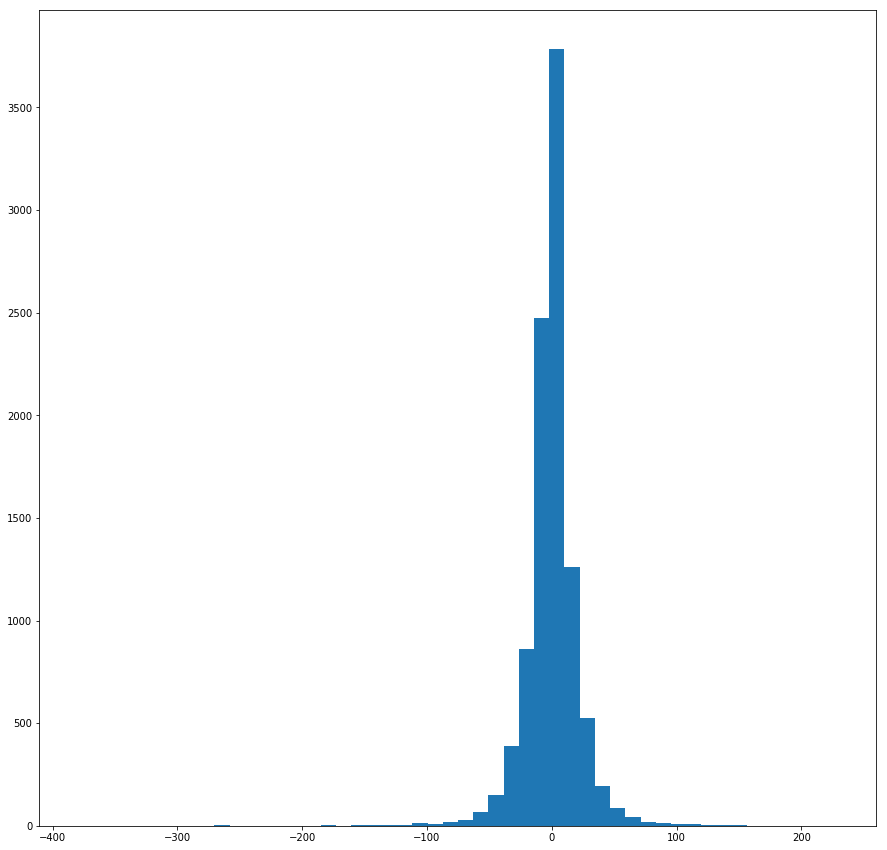

In [252]:
pCur = completePop['pysum']
plt.hist(pCur,bins=50)
print(norm.fit(pCur))
plt.show()

In [158]:
plist = [col for col in completePop if col.startswith('p')]
plist_si = [p+'_si' for p in plist]
print(plist,plist_si)

for p_si in plist_si:
    
    completePop[p_si] = completePop[p_si[:-3]] * 2e-24 


['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'px3', 'py3', 'pz3', 'pxsum', 'pysum', 'pzsum'] ['px1_si', 'py1_si', 'pz1_si', 'px2_si', 'py2_si', 'pz2_si', 'px3_si', 'py3_si', 'pz3_si', 'pxsum_si', 'pysum_si', 'pzsum_si']


In [159]:
completePop['KE1_ev'] = (completePop['px1_si']**2 + completePop['py1_si']**2 + completePop['pz1_si']**2) /(2*mass_si[0]) *6.242e18
completePop['KE2_ev'] = (completePop['px2_si']**2 + completePop['py2_si']**2 + completePop['pz2_si']**2) /(2*mass_si[1]) *6.242e18
completePop['KE3_ev'] = (completePop['px3_si']**2 + completePop['py3_si']**2 + completePop['pz3_si']**2) /(2*mass_si[2]) *6.242e18

(10000, 55)


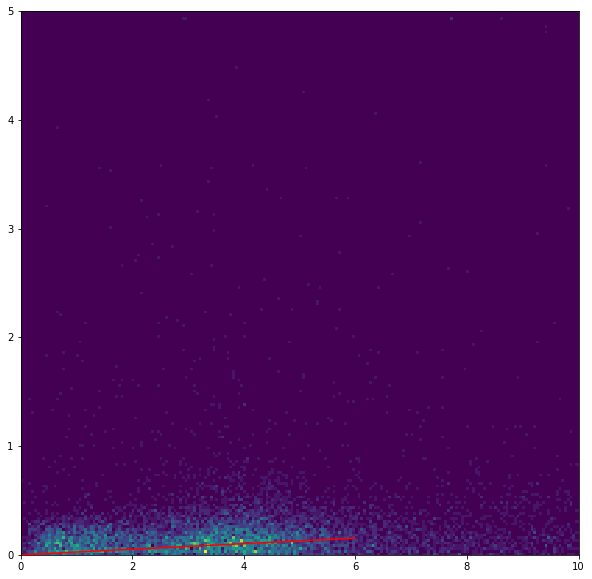

In [167]:
print(completePop.shape)
xx_ = np.arange(0,6,.01)
yy_ = xx_*(mass[1]/mass[2])

plt.hist2d(completePop.KE2_ev,completePop.KE3_ev,bins=200,range=[[0,10],[0,5]])
plt.plot(xx_,yy_,'r')
plt.show()

In [168]:
completePop['KER_ev'] = completePop['KE1_ev'] + completePop['KE2_ev'] + completePop['KE3_ev']

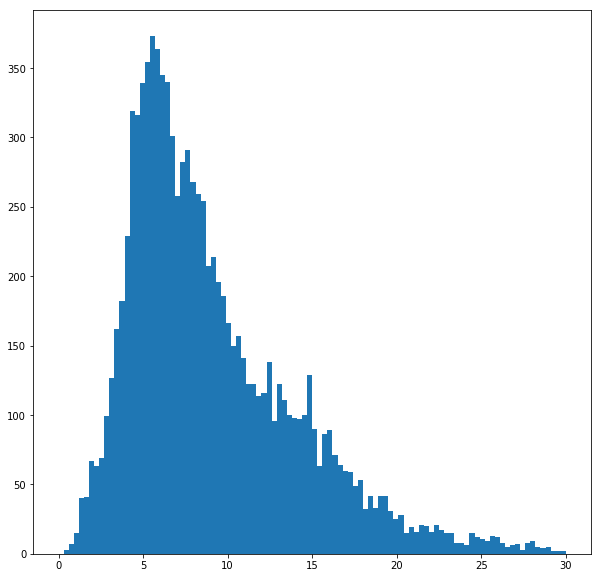

In [170]:
plt.hist(completePop.KER_ev,bins=100,range=[0,30])
plt.show()

In [171]:
completePop['ptot'] = (completePop['pxsum']**2 + completePop['pysum']**2 + completePop['pzsum']**2)**.5

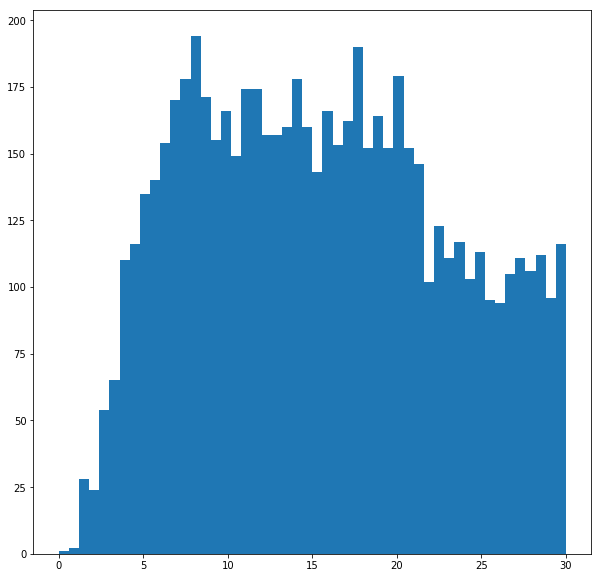

In [173]:
plt.hist(completePop.ptot,bins=50,range=[0,30])
plt.show()

(10000, 57)


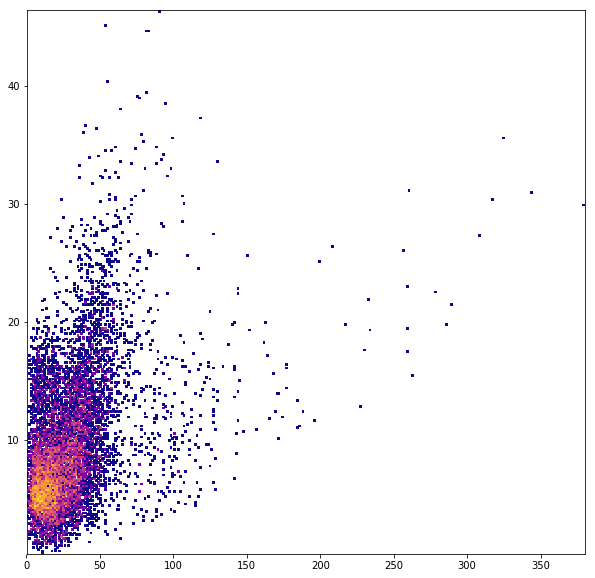

In [174]:
print(completePop.shape)
plt.hist2d(completePop.ptot,completePop.KER_ev,bins=300,norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)
plt.show()

In [175]:
keCut = completePop[completePop['ptot'] < 50]
print(keCut.shape[0]/completePop.shape[0])

0.9005


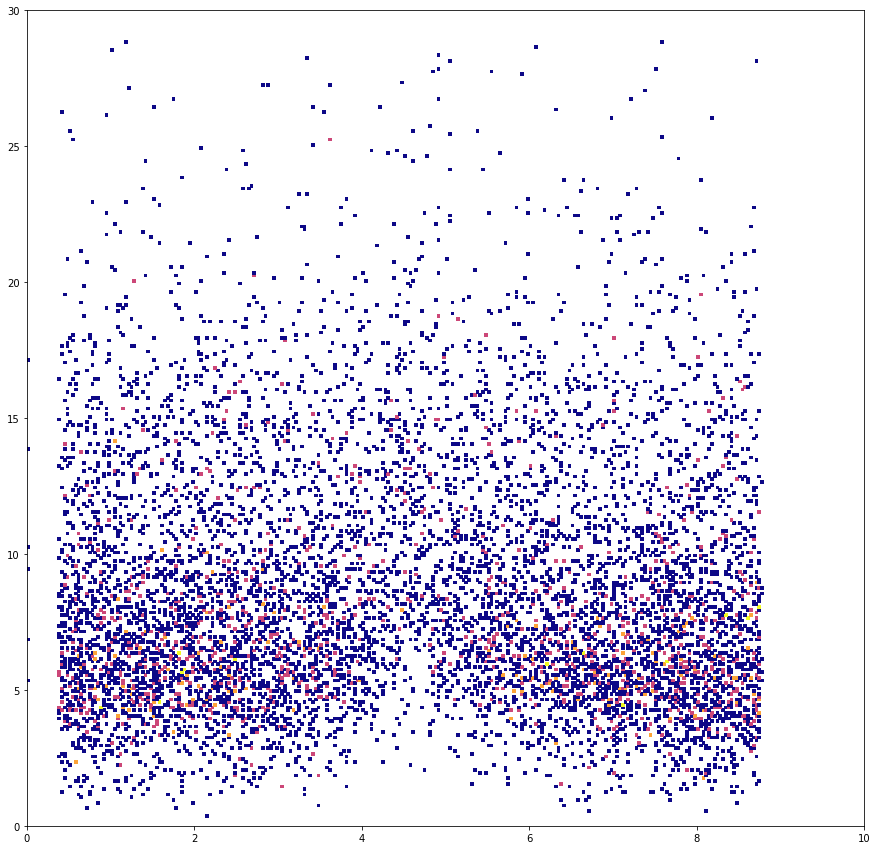

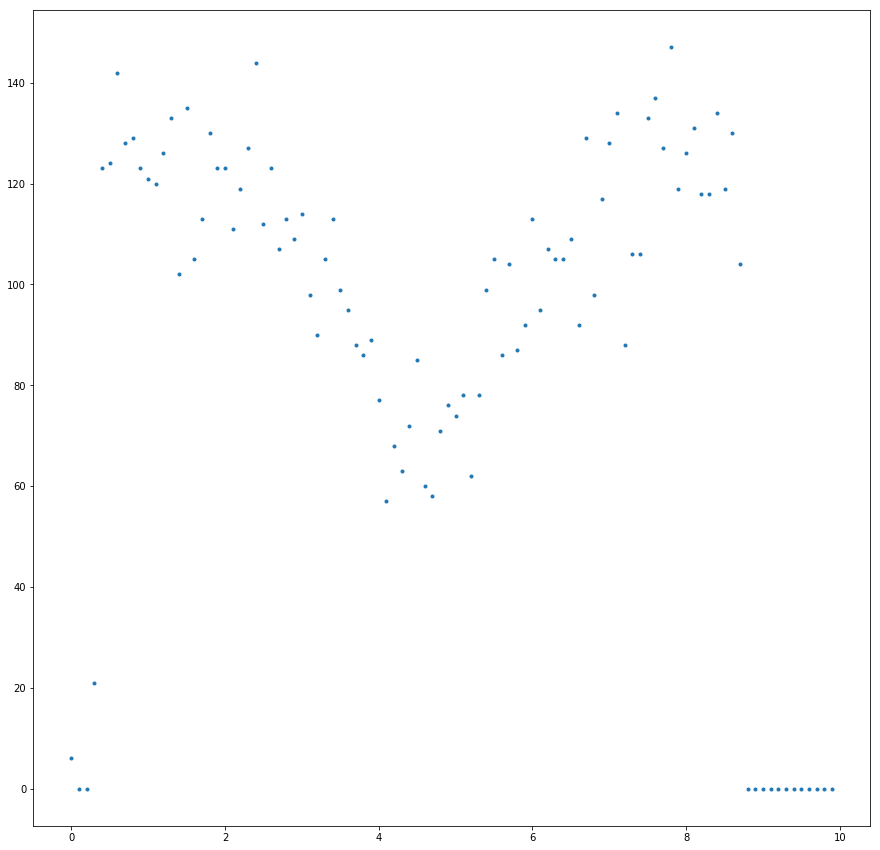

In [265]:
plt.hist2d(keCut.delay1,keCut.KER_ev,bins=300,range= [[0, 10], [0, 30]],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)
plt.show()

hist_ = fh.histogram2d(keCut.KER_ev,keCut.delay1,range= [[0,30],[0,10]],bins = 100)



plt.plot(np.arange(0,10,.1),list(hist_.sum(axis=0)),'.')
plt.show()

In [266]:
kECut = completePop[completePop['KER_ev'] < 7]


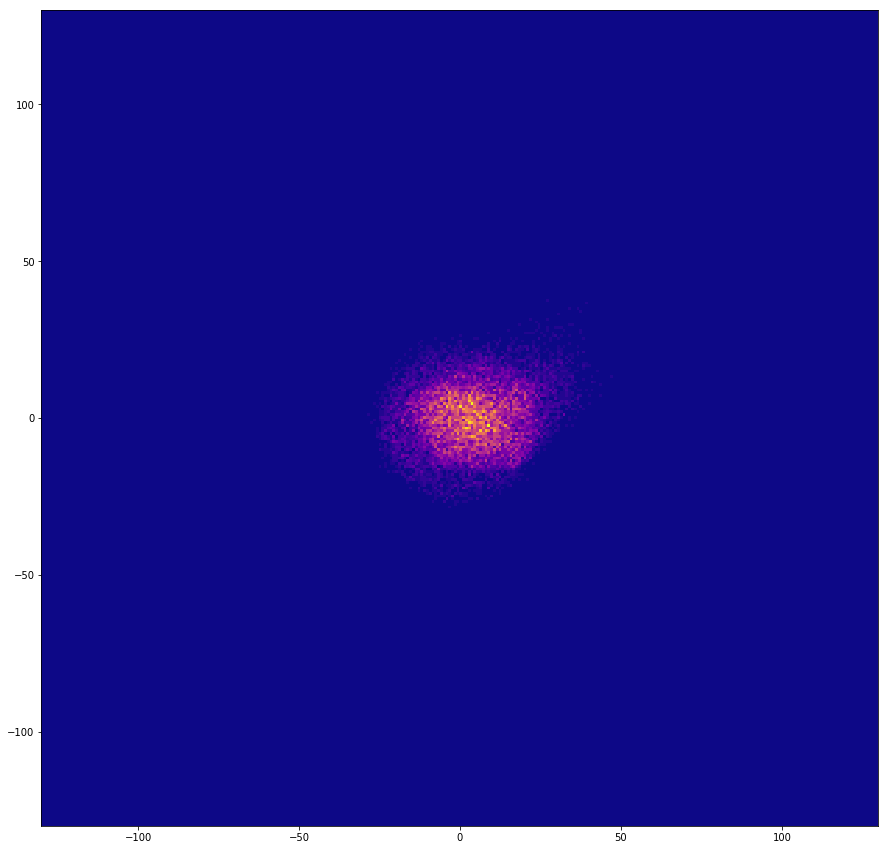

In [267]:
pX = pd.concat([kECut['px1'],kECut['px2'],keCut['pz1']])
pY = pd.concat([kECut['py1'],kECut['py2'],keCut['pz1']])
pZ = pd.concat([kECut['pz1'],kECut['pz2'],keCut['pz3']])


#plt.hist2d(kECut.pz1,kECut.px1+kECut.py1,bins=300,range=[[-100,100],[-140,120]])
plt.hist2d(pX,(pY+pZ)/np.sqrt(2),bins=300,range=[[-130,130],[-130,130]],cmap=mpl.cm.plasma)
plt.show()

In [268]:
from helper import cosineAnglefromMomenta

kECut['cos1'] = cosineAnglefromMomenta(kECut['px1'],kECut['py1'],kECut['pz1'],kECut['px3'],kECut['py3'],kECut['pz3'])
kECut['cos2'] = cosineAnglefromMomenta(kECut['px2'],kECut['py2'],kECut['pz2'],kECut['px3'],kECut['py3'],kECut['pz3'])




/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [281]:
kECut['p1tot'] = (kECut['px1']**2+kECut['py1']**2+kECut['pz1']**2)**.5
kECut['p2tot'] = (kECut['px2']**2+kECut['py2']**2+kECut['pz2']**2)**.5
#kECut['p3tot'] = (kECut['px3']**2+kECut['py3']**2+kECut['pz3']**2)**.5

kECut['newt_x1'] = kECut['cos1']*kECut['p1tot']
kECut['newt_y1'] = (kECut['p1tot']**2-kECut['newt_x1']**2)**.5

kECut['newt_x2'] = kECut['cos2']*kECut['p2tot']
kECut['newt_y2'] = -1*(kECut['p2tot']**2-kECut['newt_x2']**2)**.5



print(kECut)



              id  index1  index2  index3      x1      y1      tof1  delay1  \
10      135325.0     531     532     533  16.125  -7.310  2083.351   4.958   
16      199040.0     748     749     750   7.606  -5.880  2038.946   4.860   
27      353149.0    1425    1426    1427   4.426  17.220  2069.867   4.577   
30      395537.0    1610    1611    1612  -9.150  -9.395  2035.401   4.501   
33      446971.0    1830    1831    1832   6.043  -4.885  2041.803   4.415   
39      570251.0    2332    2333    2334 -13.655  -1.340  2067.176   4.183   
42      616852.0    2518    2519    2520  14.619   5.728  2068.963   4.114   
43      633670.0    2603    2604    2605  17.274  -7.345  2064.007   4.080   
45      646604.0    2669    2670    2671  -0.581  17.129  2076.504   4.063   
49      690099.0    2847    2848    2849 -14.425  14.613  2077.642   3.970   
52      736653.0    3054    3055    3056 -19.969   8.211  2058.634   3.906   
56      798112.0    3310    3311    3312  19.231  -0.474  2051.2

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [302]:
import matplotlib.animation as animation
from IPython.display import HTML

tmin = -50
tmax = 50
binN = 250

'''
hist1 = fh.histogram2d(kECut['newt_y1'],kECut['newt_x1'],range= [[tmin,tmax],[tmin,tmax]],bins = binN)
hist2 = fh.histogram2d(kECut['newt_y2'],kECut['newt_x2'],range= [[tmin,tmax],[tmin,tmax]],bins = binN)


hist = hist1+hist2

dx = (tmax-tmin)/binN

y, x = np.mgrid[slice(tmin, tmax + dx, dx),
slice(tmin, tmax + dx, dx)]

plt.pcolormesh(x,y,hist,norm=mpl.colors.LogNorm() )
plt.rcParams["figure.figsize"] = [15,15]
plt.show()
'''

step_n = 3
max_delay = 1300

step_size = (8.776-4.6)/step_n
delay_step= max_delay/step_n

def newt_getslice(n):

    cent = 4.6
    maxi = 8.778 

    lowp = cent+ step_size*n
    higp = cent+ step_size*(n+1)
    
    lowm = cent- step_size*n
    higm = cent- step_size*(n+1)
    
    
    
    
    x1 = pd.concat([kECut['newt_x1'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_x1'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    y1 = pd.concat([kECut['newt_y1'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_y1'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    
    x2 = pd.concat([kECut['newt_x2'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_x2'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    y2 = pd.concat([kECut['newt_y2'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_y2'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    
    hist1 = fh.histogram2d(y1,x1,range= [[tmin,tmax],[tmin,tmax]],bins = binN)
    hist2 = fh.histogram2d(y2,x2,range= [[tmin,tmax],[tmin,tmax]],bins = binN)
    
    hist = hist1+hist2

    print(hist.sum())
    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist,norm=mpl.colors.LogNorm())
    plt.rcParams["figure.figsize"] = [15,15]

    plt.title(str(int(delay_step*n))+' to '+str(int(delay_step*(n+1)))+' fs')
    plt.ylabel('Momentum (AU)')
    plt.xlabel('Momentum (AU)')
    #plt.show()
    plt.savefig('tmp'+str(n)+'.png')
    plt.close()

for i in range(step_n):   
    newt_getslice(i)


1600.0
3162.0
3666.0
